In [2]:

# # IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# # TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# # THEN FEEL FREE TO DELETE THIS CELL.
# # NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# # ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# # NOTEBOOK.

# import os
# import sys
# from tempfile import NamedTemporaryFile
# from urllib.request import urlopen
# from urllib.parse import unquote, urlparse
# from urllib.error import HTTPError
# from zipfile import ZipFile
# import tarfile
# import shutil

# CHUNK_SIZE = 40960
# DATA_SOURCE_MAPPING = 'dl-a5-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4891196%2F8244595%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240427%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240427T120724Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6a3816b3d48e7d5edb3cf8a77807c18c838bb7afa3db50b70f97ea92f0fd9b523ae8df6de239e46d9087a1af4bcc53fbd76bcafe13e817d8b145be08050d95071928add94265be1c21b2b419367d1d7fa6e3fed379af9eb8a49f189180654bb815a8b20d2b07c96e56ef02ec418e1b3bb40a24dd8fcfa76fcd5208946a96baeb349182b1ba4e4e48a768547d71725753a52e35c5211a17d1b185c5a3f46cf5d04a46a1e61b5a43866520cf4a5aab5db0cfc671dfc5220f798e2d2544f458e48a585c9a4790e32c75172d7f742307ce34ed0242faca29f08ca11333a5006488fad0afa720127eb0ca6f90bfff36f908ae0bcb409c83a91ccac8e1490d1f83bb11'

# KAGGLE_INPUT_PATH='/kaggle/input'
# KAGGLE_WORKING_PATH='/kaggle/working'
# KAGGLE_SYMLINK='kaggle'

# !umount /kaggle/input/ 2> /dev/null
# shutil.rmtree('/kaggle/input', ignore_errors=True)
# os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
# os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

# try:
#   os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
# except FileExistsError:
#   pass
# try:
#   os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
# except FileExistsError:
#   pass

# for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
#     directory, download_url_encoded = data_source_mapping.split(':')
#     download_url = unquote(download_url_encoded)
#     filename = urlparse(download_url).path
#     destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
#     try:
#         with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
#             total_length = fileres.headers['content-length']
#             print(f'Downloading {directory}, {total_length} bytes compressed')
#             dl = 0
#             data = fileres.read(CHUNK_SIZE)
#             while len(data) > 0:
#                 dl += len(data)
#                 tfile.write(data)
#                 done = int(50 * dl / int(total_length))
#                 sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
#                 sys.stdout.flush()
#                 data = fileres.read(CHUNK_SIZE)
#             if filename.endswith('.zip'):
#               with ZipFile(tfile) as zfile:
#                 zfile.extractall(destination_path)
#             else:
#               with tarfile.open(tfile.name) as tarfile:
#                 tarfile.extractall(destination_path)
#             print(f'\nDownloaded and uncompressed: {directory}')
#     except HTTPError as e:
#         print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
#         continue
#     except OSError as e:
#         print(f'Failed to load {download_url} to path {destination_path}')
#         continue

# print('Data source import complete.')


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

# [VQ-VAE](https://arxiv.org/abs/1711.00937) by  [Aäron van den Oord](https://twitter.com/avdnoord) et al. in PyTorch

## Introduction

Variational Auto Encoders (VAEs) can be thought of as what all but the last layer of a neural network is doing, namely feature extraction or seperating out the data. Thus given some data we can think of using a neural network for representation generation.

Recall that the goal of a generative model is to estimate the probability distribution of high dimensional data such as images, videos, audio or even text by learning the underlying structure in the data as well as the dependencies between the different elements of the data. This is very useful since we can then use this representation to generate new data with similar properties. This way we can also learn useful features from the data in an unsupervised fashion.

The VQ-VAE uses a discrete latent representation mostly because many important real-world objects are discrete. For example in images we might have categories like "Cat", "Car", etc. and it might not make sense to interpolate between these categories. Discrete representations are also easier to model since each category has a single value whereas if we had a continous latent space then we will need to normalize this density function and learn the dependencies between the different variables which could be very complex.

### Code

I have followed the code from the TensorFlow implementation by the author which you can find here [vqvae.py](https://github.com/deepmind/sonnet/blob/master/sonnet/python/modules/nets/vqvae.py) and [vqvae_example.ipynb](https://github.com/deepmind/sonnet/blob/master/sonnet/examples/vqvae_example.ipynb).

Another PyTorch implementation is found at [pytorch-vqvae](https://github.com/ritheshkumar95/pytorch-vqvae).


## Basic Idea

The overall architecture is summarized in the diagram below:

![](https://github.com/zalandoresearch/pytorch-vq-vae/blob/master/images/vq-vae.png?raw=1)

We start by defining a latent embedding space of dimension `[K, D]` where `K` are the number of embeddings and `D` is the dimensionality of each latent embeddng vector, i.e. $e_i \in \mathbb{R}^{D}$. The model is comprised of an encoder and a decoder. The encoder will map the input to a sequence of discrete latent variables, whereas the decoder will try to reconstruct the input from these latent sequences.

More preciesly, the model will take in batches of RGB images,  say $x$, each of size 32x32 for our example, and pass it through a ConvNet encoder producing some output $E(x)$, where we make sure the channels are the same as the dimensionality of the latent embedding vectors. To calculate the discrete latent variable we find the nearest embedding vector and output it's index.

The input to the decoder is the embedding vector corresponding to the index which is passed through the decoder to produce the reconstructed image.

Since the nearest neighbour lookup has no real gradient in the backward pass we simply pass the gradients from the decoder to the encoder  unaltered. The intuition is that since the output representation of the encoder and the input to the decoder share the same `D` channel dimensional space, the gradients contain useful information for how the encoder has to change its output to lower the reconstruction loss.

## Loss

The total loss is actually composed of three components

1. **reconstruction loss**: which optimizes the decoder and encoder
1. **codebook loss**: due to the fact that gradients bypass the embedding, we use a dictionary learning algorithm  which uses an $l_2$  error to move the embedding vectors $e_i$ towards the encoder output
1. **commitment loss**:  since the volume of the embedding space is dimensionless, it can grow arbirtarily if the embeddings $e_i$ do not train as fast as  the encoder parameters, and thus we add a commitment loss to make sure that the encoder commits to an embedding

In [4]:
#!pip3 install -U -r requirements.txt

In [5]:
# from __future__ import print_function


import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter


# from six.moves import xrange

# import umap
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader , Dataset
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load Data

In [7]:
import os
from glob import glob1
# from torchvision.io import read_image
from PIL.Image import open as open_image

class CustomImageDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.img_dir = glob1(root, '*.jpg') + glob1(root, '*.png') + glob1(root, '*.jpeg')
        self.transform = transform


    def __len__(self):
        return len(self.img_dir)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.img_dir[idx])
        image = open_image(img_path)
        if self.transform:
            image = self.transform(image)
        return image

In [8]:
# training_data = CustomImageDataset(root=r"/kaggle/input/dl-a5-data/Train_data-001/Train_data", transform=transforms.Compose([ transforms.CenterCrop(128),transforms.ToTensor(), transforms.Normalize(mean=(0, 0, 0), std=(1, 1, 1))]))
# train_loader = DataLoader(training_data, batch_size=256, shuffle=False)
# # placeholders
# psum = torch.tensor([0.0, 0.0, 0.0])
# psum_sq = torch.tensor([0.0, 0.0, 0.0])

# # loop through images
# imgs = []
# for inputs in tqdm(train_loader):
#     psum += inputs.sum(axis=[0, 2, 3])
#     psum_sq += (inputs**2).sum(axis=[0, 2, 3])
#     imgs.append(inputs)
# data_isic = torch.cat(imgs, dim=0)
# data_variance = torch.var(data_isic)


In [9]:
# ####### FINAL CALCULATIONS

# # pixel count
# count = len(training_data) * 128 * 128

# # mean and std
# total_mean = psum / count
# total_var = (psum_sq / count) - (total_mean**2)
# total_std = torch.sqrt(total_var)

# # output
# print("mean: " + str(total_mean))
# print("std:  " + str(total_std))
# print('var' , data_variance)

In [10]:
mean =  (0.6567, 0.3680, 0.3743)
std =   (0.1701, 0.1709, 0.1831)
data_variance = 0.0487
# root = "/kaggle/input/dl-a5-data/"
root = r'D:/programming/Assignment_5'
training_data = CustomImageDataset(root=root + "/Train_data",
                                  transform=transforms.Compose([
                                      transforms.RandomHorizontalFlip(0.4),
                                    transforms.RandomRotation(10),
                                    # transforms.RandomCrop(128, padding=4, padding_mode='reflect'),
                                      transforms.CenterCrop(128),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean, std)
                                  ]))

validation_data = CustomImageDataset(root=root + "/Test/Test_data",
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean, std)]))

## Vector Quantizer Layer

This layer takes a tensor to be quantized. The channel dimension will be used as the space in which to quantize. All other dimensions will be flattened and will be seen as different examples to quantize.

The output tensor will have the same shape as the input.

As an example for a `BCHW` tensor of shape `[16, 64, 32, 32]`, we will first convert it to an `BHWC` tensor of shape `[16, 32, 32, 64]` and then reshape it into `[16384, 64]` and all `16384` vectors of size `64`  will be quantized independently. In otherwords, the channels are used as the space in which to quantize. All other dimensions will be flattened and be seen as different examples to quantize, `16384` in this case.

In [11]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)

        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss

        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

We will also implement a slightly modified version  which will use exponential moving averages to update the embedding vectors instead of an auxillary loss. This has the advantage that the embedding updates are independent of the choice of optimizer for the encoder, decoder and other parts of the architecture. For most experiments the EMA version trains faster than the non-EMA version.

In [12]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost

        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()

        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)

        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)

            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)

            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)

            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss

        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

## Encoder & Decoder Architecture

The encoder and decoder architecture is based on a ResNet and is implemented below:

In [13]:
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels=in_channels,
                      out_channels=num_residual_hiddens,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=num_residual_hiddens,
                      out_channels=num_hiddens,
                      kernel_size=1, stride=1, bias=False)
        )

    def forward(self, x):
        return x + self._block(x)


class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens)
                             for _ in range(self._num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)

In [14]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = F.relu(x)

        x = self._conv_2(x)
        x = F.relu(x)

        x = self._conv_3(x)
        return self._residual_stack(x)

In [15]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Decoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)

        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

        self._conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hiddens,
                                                out_channels=num_hiddens//2,
                                                kernel_size=4,
                                                stride=2, padding=1)

        self._conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens//2,
                                                out_channels=3,
                                                kernel_size=4,
                                                stride=2, padding=1)

    def forward(self, inputs):
        x = self._conv_1(inputs)

        x = self._residual_stack(x)

        x = self._conv_trans_1(x)
        x = F.relu(x)

        return self._conv_trans_2(x)

## Train

We use the hyperparameters from the author's code:

In [16]:
batch_size = 256
num_training_updates = 15000

num_hiddens = 64 #128
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 128
num_embeddings = 512

commitment_cost = 0.25

decay = 0.99

learning_rate = 1e-3

In [17]:
# training_loader = DataLoader(training_data,
#                              batch_size=batch_size,
#                              shuffle=True,
#                              pin_memory=True,
#                             num_workers = 0)

In [18]:
# validation_loader = DataLoader(validation_data,
#                                batch_size=32,
#                                shuffle=True,
#                                pin_memory=True,
#                               num_workers  = 0)

In [19]:
class Model(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
                 num_embeddings, embedding_dim, commitment_cost, decay=0):
        super(Model, self).__init__()

        self._encoder = Encoder(3, num_hiddens,
                                num_residual_layers,
                                num_residual_hiddens)
        self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens,
                                      out_channels=embedding_dim,
                                      kernel_size=1,
                                      stride=1)
        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim,
                                              commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost)
        self._decoder = Decoder(embedding_dim,
                                num_hiddens,
                                num_residual_layers,
                                num_residual_hiddens)

    def forward(self, x):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        print(z.shape,'here')
        loss, quantized, perplexity, _ = self._vq_vae(z)
        x_recon = self._decoder(quantized)

        return loss, x_recon, perplexity

In [20]:
model = Model(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim,
              commitment_cost, decay)
ngpu = torch.cuda.device_count()
if ngpu > 1:
    model =  nn.DataParallel(model)
model = model.to(device)

In [21]:
def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
def denorm(img_tensors,mean,std):
    stats_image = (mean,std)
    return img_tensors * stats_image[1][0] + stats_image[0][0]

In [22]:
# optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

In [23]:
# model.train()
# train_res_recon_error = []
# train_res_perplexity = []
# epochs = 50
# for i in range(epochs):
#     for data in tqdm(training_loader):
#         data = data.to(device)
#         optimizer.zero_grad()

#         vq_loss, data_recon, perplexity = model(data)
#         recon_error = F.mse_loss(data_recon, data) / data_variance
#         loss = recon_error + vq_loss
#         loss.backward()

#         optimizer.step()

#         train_res_recon_error.append(recon_error.item())
#         train_res_perplexity.append(perplexity.item())
#         # break

#         # if (i+1) % 100 == 0:

#     print(f'epoch: {i+1}/{epochs} ')
#     print('%d iterations' % ((i+1)*len(training_loader)))
#     print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
#     print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
#     show(make_grid(denorm(data[:16].cpu().data,mean,std)))
#     plt.show()
#     show(make_grid(denorm(data_recon[:16].cpu().data,mean,std)))
#     plt.show()

#     state_dict = {
#         'model': model.state_dict(),
#         'epochs':i,
#         'recon_error': np.mean(train_res_recon_error[-100:]),
#         'perplexity': np.mean(train_res_perplexity[-100:]),
#     }
#     torch.save(state_dict,'/content/drive/MyDrive/DL_A5/model_vqvae.pth')
#     print('model saved')
#     print()
#     # break


## Plot Loss

In [24]:
# train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)
# train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 201, 7)

In [25]:
# f = plt.figure(figsize=(16,8))
# ax = f.add_subplot(1,2,1)
# ax.plot(train_res_recon_error_smooth)
# ax.set_yscale('log')
# ax.set_title('Smoothed NMSE.')
# ax.set_xlabel('iteration')

# ax = f.add_subplot(1,2,2)
# ax.plot(train_res_perplexity_smooth)
# ax.set_title('Smoothed Average codebook usage (perplexity).')
# ax.set_xlabel('iteration')

## View Reconstructions

In [26]:
# model.eval()

# (valid_originals) = next(iter(validation_loader))
# valid_originals = valid_originals.to(device)

# vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
# _, valid_quantize, _, encodings = model._vq_vae(vq_output_eval)
# valid_reconstructions = model._decoder(valid_quantize)

In [27]:
# (train_originals) = next(iter(training_loader))
# train_originals = train_originals.to(device)
# _, train_reconstructions, _, _ = model._vq_vae(train_originals)

In [28]:
# show(make_grid(denorm(valid_reconstructions.cpu().data,mean,std)))

In [29]:
# show(make_grid(denorm(valid_originals.cpu().data,mean,std)))

## View Embedding

In [30]:
# torch.save(model.state_dict(), 'model_vqvae_e50.pth')

In [31]:
# !pip install umap-learn
# import umap

In [32]:
# proj = umap.UMAP(n_neighbors=3,
#                  min_dist=0.1,
#                  metric='cosine').fit_transform(model._vq_vae._embedding.weight.data.cpu())

In [33]:
# plt.scatter(proj[:,0], proj[:,1], alpha=0.3)

# Model Inference 

In [34]:
model.load_state_dict(torch.load('./model_vqvae.pth')['model'])

<All keys matched successfully>

In [35]:
# model(input)
model.eval()

Model(
  (_encoder): Encoder(
    (_conv_1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (_conv_2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (_conv_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (_residual_stack): ResidualStack(
      (_layers): ModuleList(
        (0-1): 2 x Residual(
          (_block): Sequential(
            (0): ReLU(inplace=True)
            (1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (2): ReLU(inplace=True)
            (3): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
        )
      )
    )
  )
  (_pre_vq_conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
  (_vq_vae): VectorQuantizerEMA(
    (_embedding): Embedding(512, 128)
  )
  (_decoder): Decoder(
    (_conv_1): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (_residual_stack): ResidualStack(
      (_layers): ModuleList

In [36]:
embedding_dim = 128
num_embeddings = 512

torch.Size([16384, 1])


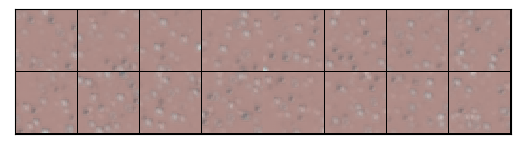

In [37]:
N = 16
input_shape = (N, 32, 32, 128)
z = torch.randint(0, num_embeddings, (N*32*32,)).unsqueeze(1).to(device)
encodings = torch.zeros(z.shape[0], num_embeddings, device=device)
encodings.scatter_(1, z, 1)
# Quantize and unflatten
print(z.shape)
quantized = torch.matmul(encodings, model._vq_vae._embedding.weight).view(input_shape).permute(0, 3, 1, 2)

x_recon = model._decoder(quantized)
show(make_grid(denorm(x_recon.cpu().data,mean,std)))

In [80]:
import torch
import torch.nn as nn
from torch.nn import functional as F


# hyperparameters
batch_size = 128 # how many independent sequences will we process in parallel?
block_size = 256 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 500
learning_rate = 4e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 128 # embedding dimension
n_head = 6
n_layer = 6
dropout = 0.2
vocab_size = 512 + 2 #number of embeddings in the VQ-VAE
torch.manual_seed(1337)

In [81]:


class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)  # This token embedding is already fixed
        # self.token_embedding_table  = vq_vae_embedding
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C) 
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


In [82]:
batch_size = 1
training_loader = DataLoader(training_data,
                             batch_size=batch_size,
                             shuffle=True,
                             pin_memory=True,
                            num_workers = 0)
validation_loader = DataLoader(validation_data,
                               batch_size=1,
                               shuffle=True,
                               pin_memory=True,
                              num_workers  = 0)

In [83]:
valid_originals = next(iter(training_loader))
# data = data.to(device)
input_shape = (batch_size,32,32,128)
valid_originals = valid_originals.to(device)

vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
_, valid_quantize, _, encodings = model._vq_vae(vq_output_eval)
valid_reconstructions = model._decoder(valid_quantize)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


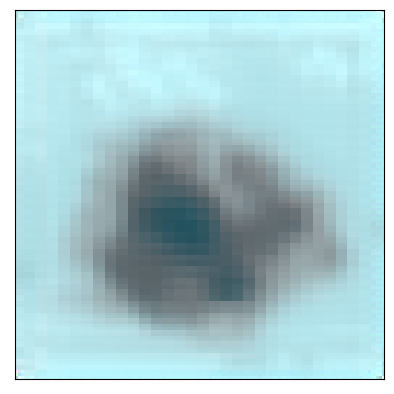

In [84]:
show(make_grid(denorm(valid_reconstructions.cpu().data,mean,std)))

In [86]:
start = torch.tensor([512], dtype=torch.long).to(device)
end = torch.tensor([513], dtype=torch.long).to(device)

In [120]:
import wandb

In [121]:

modelgpt = GPTLanguageModel()
m = modelgpt.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(modelgpt.parameters(), lr=learning_rate)

@torch.no_grad()
def estimate_loss(training_loader, validation_loader):
    out = {}
    modelgpt.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            if split == 'train':
                valid_originals = next(iter(training_loader))
            else:
                valid_originals = next(iter(validation_loader))
            # data = data.to(device)
            valid_originals = valid_originals.to(device)
            vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
            _, valid_quantize, _, encodings = model._vq_vae(vq_output_eval)
            valid_reconstructions = model._decoder(valid_quantize)
            encodings = torch.concat((start,encodings.argmax(dim=-1).flatten(),end),dim=0)
            X, Y = get_batch(encodings)
            logits, loss = modelgpt(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    modelgpt.train()
    return out
# # data loading
def get_batch(data):
    # generate a small batch of data of inputs x and targets y
    # data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y
input_shape = (batch_size,32,32,128)

run = wandb.init(
    project="VQVAE",
    entity = 'khadgaa')
wandb.watch(modelgpt)


for iters in tqdm(range(max_iters)):

    # every once in a while evaluate the loss on train and val sets
    if iters % eval_interval == 0 or iters == max_iters - 1:
        losses = estimate_loss(training_loader, validation_loader)
        print(f"step {iters}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        wandb.log(losses)
    # sample a batch of data
    
        valid_originals = next(iter(training_loader))
        # data = data.to(device)

        valid_originals = valid_originals.to(device)

        vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
        _, valid_quantize, _, encodings = model._vq_vae(vq_output_eval)
        valid_reconstructions = model._decoder(valid_quantize)
        encodings = torch.concat((start,encodings.argmax(dim=-1).flatten(),end),dim=0)
        xb, yb = get_batch(encodings)

        # evaluate the loss
        logits, loss = modelgpt(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()


1.346306 M parameters


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: khadgaa. Use `wandb login --relogin` to force relogin


  0%|          | 0/5000 [00:00<?, ?it/s]

step 0: train loss 6.1996, val loss 6.2420


  0%|          | 1/5000 [00:32<45:42:54, 32.92s/it]

step 500: train loss 6.0359, val loss 6.1071


 10%|█         | 501/5000 [01:17<08:10,  9.17it/s] 

step 1000: train loss 6.0285, val loss 6.1138


 30%|███       | 1501/5000 [02:26<04:59, 11.69it/s]

step 1500: train loss 6.0361, val loss 6.2110


 40%|████      | 2001/5000 [03:00<03:57, 12.64it/s]

step 2000: train loss 5.9949, val loss 6.0584


 40%|████      | 2001/5000 [03:17<03:57, 12.64it/s]

step 2500: train loss 5.9313, val loss 5.7888


 60%|██████    | 3001/5000 [03:56<02:10, 15.31it/s]

step 3000: train loss 5.8311, val loss 5.6286


 60%|██████    | 3001/5000 [04:07<02:10, 15.31it/s]

step 3500: train loss 5.8035, val loss 5.5136


 80%|████████  | 4001/5000 [04:49<00:58, 17.03it/s]

step 4000: train loss 5.6953, val loss 5.4630


 80%|████████  | 4001/5000 [05:07<00:58, 17.03it/s]

step 4500: train loss 5.6894, val loss 5.4274


 90%|█████████ | 4501/5000 [05:27<00:26, 18.53it/s]

step 4999: train loss 5.6041, val loss 5.3857


100%|██████████| 5000/5000 [05:36<00:00, 14.84it/s]


In [89]:
# valid_originals = next(iter(training_loader))

In [122]:
context = torch.tensor([[512]], dtype=torch.long, device=device)
generated_encode  = m.generate(context , max_new_tokens=1025)

In [123]:
generated_encode = generated_encode[:,1:-1]

In [124]:
generated_encode.shape

torch.Size([1, 1024])

In [125]:
torch.unique(generated_encode)

tensor([  0,   1,   3,   4,   5,   7,   8,   9,  10,  11,  12,  13,  14,  16,
         17,  19,  20,  21,  22,  23,  24,  25,  27,  28,  29,  30,  31,  32,
         33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  44,  45,  46,  47,
         48,  49,  51,  52,  53,  54,  55,  56,  57,  58,  60,  61,  62,  63,
         64,  65,  66,  67,  68,  70,  71,  72,  73,  74,  77,  78,  80,  81,
         82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  95,  96,
         97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 109, 111, 112,
        113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
        127, 128, 130, 131, 132, 133, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 153, 156, 157, 158, 159,
        162, 163, 164, 165, 166, 167, 169, 170, 171, 172, 173, 174, 175, 178,
        179, 180, 181, 183, 186, 187, 188, 190, 192, 193, 194, 195, 196, 197,
        198, 199, 200, 201, 203, 204, 206, 207, 208, 209, 210, 2

In [126]:
generated_encode = torch.where(generated_encode==512,torch.tensor(0),generated_encode)
generated_encode = torch.where(generated_encode==513,torch.tensor(0),generated_encode)


In [127]:
torch.unique(generated_encode)

tensor([  0,   1,   3,   4,   5,   7,   8,   9,  10,  11,  12,  13,  14,  16,
         17,  19,  20,  21,  22,  23,  24,  25,  27,  28,  29,  30,  31,  32,
         33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  44,  45,  46,  47,
         48,  49,  51,  52,  53,  54,  55,  56,  57,  58,  60,  61,  62,  63,
         64,  65,  66,  67,  68,  70,  71,  72,  73,  74,  77,  78,  80,  81,
         82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  95,  96,
         97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 109, 111, 112,
        113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
        127, 128, 130, 131, 132, 133, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 153, 156, 157, 158, 159,
        162, 163, 164, 165, 166, 167, 169, 170, 171, 172, 173, 174, 175, 178,
        179, 180, 181, 183, 186, 187, 188, 190, 192, 193, 194, 195, 196, 197,
        198, 199, 200, 201, 203, 204, 206, 207, 208, 209, 210, 2

In [128]:
generated_encode.T.shape

torch.Size([1024, 1])

In [129]:
generated_encode = generated_encode.T

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


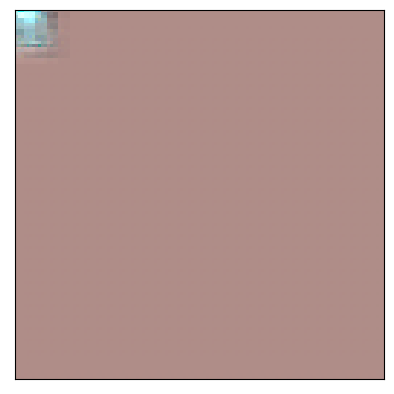

In [130]:
encodings = torch.zeros(generated_encode.shape[0], num_embeddings, device=device)
encodings.scatter_(1, generated_encode.T, 1)
quantized = torch.matmul(encodings, model._vq_vae._embedding.weight).view(input_shape).permute(0, 3, 1, 2)

x_recon = model._decoder(quantized)
show(make_grid(denorm(x_recon.cpu().data,mean,std)))

In [99]:
# m.generate([start],500)

In [ ]:
# next character prediction. 
#  windowed prediction